# Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pyvisa # control gpib, tcp/ip etc...
import nidaqmx # Control ni-usb-6002
import paramiko
from scp import SCPClient   
import os
from matplotlib.animation import FuncAnimation
from itertools import count
import cv2
import natsort
import scipy
import lmfit

######### Module for c++
# import clr
# from System import Decimal

# for APT control of thorlab stages
from pylablib.devices import Thorlabs

# After rm_listsource does not show USB's....This is a longer way to take control over PM160
from ctypes import cdll,c_long, c_ulong, c_uint32,byref,create_string_buffer,c_bool,c_char_p,c_int,c_int16,c_double, sizeof, c_voidp
from TLPM import TLPM # TLPM.py is required

# Instruments

In [6]:
rm = pyvisa.ResourceManager()

In [7]:
rm.list_resources()

('USB0::0x1313::0x807B::16041103::INSTR',
 'TCPIP0::192.168.0.2::inst0::INSTR',
 'ASRL1::INSTR',
 'ASRL4::INSTR',
 'ASRL5::INSTR',
 'ASRL6::INSTR',
 'ASRL7::INSTR',
 'ASRL8::INSTR',
 'GPIB0::6::INSTR')

In [8]:
smf100a=rm.open_resource('TCPIP::192.168.0.2::hislip0::INSTR');time.sleep(0.5) 

In [9]:
ghost=rm.open_resource('TCPIP::localhost::4000::SOCKET');time.sleep(1)
ghost.read_termination='\r\n';time.sleep(1)

In [10]:
kepco=rm.open_resource('GPIB0::6::INSTR');time.sleep(0.5)

In [11]:
#pna5230a=rm.open_resource('GPIB0::5::INSTR');time.sleep(0.5)

# User defined functions

In [44]:
cap = cv2.VideoCapture(1)

In [45]:
ret, frame = cap.read()

In [46]:
out = cv2.imwrite('test4.png', frame)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [42]:
def takepic2(picture_name):
    cap = cv2.VideoCapture(3)
    ret, frame = cap.read()
    out = cv2.imwrite(picture_name, frame)
    time.sleep(0.5)
    cap.release()
    cv2.destroyAllWindows()

In [43]:
takepic2('test2.png')

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [ ]:
cap = cv2.VideoCapture(0)

In [ ]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
out = cv2.imwrite(picture_name, frame)
time.sleep(0.5)
cap.release()
cv2.destroyAllWindows()

In [12]:
##############################   kepco  ########################################         
def init_kepco_local():
    kepco.write('FUNC:MODE CURR')
    kepco.write('CURR 0.00000')
    kepco.write('OUTP ON')
    return

def change_curr_local(curr):
    kepco.write('CURR %.4f'%curr)
    return

##############################   PSP  ######################################## 
def change_volt_PSP(volt):
    PSP603.write('SV %.2f'%volt);
    return volt

def PSP_seq_volt(volt):
    tlist=np.linspace(0,5,100)
    vlist=volt+volt*np.sin(tlist*2*np.pi/0.2)*np.exp(-tlist**2/3)
    tstep=(tlist[1]-tlist[0])
    print('PSP voltage stablization is running...')
    for i,v in enumerate(vlist):
        change_volt_PSP(v);time.sleep(tstep)

##############################   lockin  ######################################## 
def getAvg(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
def getAvgY(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
    
def getAvg_GPIB(i):
    return float(sr830a.query('OUTP? %i'%i).split('\n')[0])

def getAvg_GPIB_TRAC():
    sr830a.write('REST')
    sr830a.write('STRD')
    time.sleep(1)
    return np.mean([float(x) for x in sr830a.query('TRCA? 1,0,20').split(',')[:-1]])    
# second lockin for Pt voltage
def getlock2x(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
    
def getlock2y(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
    
def adjust_sens():
    senslist=np.array([2e-6,5e-6,10e-6,20e-6,50e-6,100e-6,200e-6,500e-6,1e-3,2e-3,5e-3,10e-3,20e-3,50e-3,100e-3,200e-3,500e-3,\
                  1,2,5,10,20,50,100,200,500,1000])
    
    init_sens=14 # 16 = 0.1 mV
    sr830a.write('SENS %i'%(init_sens))
    print(f'Sens is adjusted to {senslist[init_sens]} mV...')
    time.sleep(0.1)
    i=0
    while float(sr830a.query('LIAS? 2').split('\n')[0])==1:
        i=i+1
        sr830a.write('SENS %i'%(init_sens+i))
        print(f'Sens is adjusted to {senslist[init_sens+i]} mV...')
        time.sleep(0.1)
#         float(sr830a.query('LIAS? 2').split('\n')[0])#clear bit 2
    sr830a.write('SENS %i'%(init_sens+i+1))
    print(f'Sens is adjusted to {senslist[init_sens+i+1]} mV...')
    time.sleep(0.1)
    return senslist[init_sens+i+1]    

##############################   microwave  ######################################## 
def change_power(power):
    smf100a.write('SOUR:POW %.10f'%power)
    return

def turnMW_on_off(control):
    smf100a.write("OUTP:All %s"%control)
    return

def change_freq(freq):
    smf100a.write('SOUR:FREQ %.10f'%freq)
    return freq

def change_mod(control):
    smf100a.write('SOUR:Mod %s'%control)
    return

def init_LFO():               
    smf100a.write('SOUR:LFO1:VOLT %.10f'%2.5) # 2.5 is good for simulating TTL for lockin ref
    smf100a.write('SOUR:LFO1 ON')
    smf100a.write('SOUR:LFO1:OFFS 0')
def set_LFO_pulse(wid,peri):   
    
    smf100a.write('SOUR:LFO1:SHAP:PULS:WIDT %.10f'%wid)
    smf100a.write('SOUR:LFO1:SHAP:PULS:PER %.10f'%peri)
    
##############################   file i/o  ######################################## 
def save_header(pfile, outputfile, header, flag='w') :
    with open(pfile) as fp:
        content = fp.readlines()
        fp.close()
    with open(outputfile, flag) as fp:
        for line in content:
            print('#', line[:-1], file=fp)
        if flag == 'w': print('#', header, file=fp)
        fp.close()
    return
    
def stopper(pfile):
    with open(pfile) as fp:
        content = fp.readlines()
        fp.close()
    return content[0].split('\n')[0]

def read_linenum(pfile):
    with open(pfile) as fp:
        content = fp.readlines()
        fp.close()
        i=0
        while len(content[-i-1].split('::::'))==1:
            i=i+1
    return int(content[-i-2].split(':')[0])

##############################   ghost  ######################################## 
def check_ghost_acquiring(sweepcount,BLScount):
    global error_occured
    error_occured=0
    status='Template:  on'
    while status.split(':')[1].split('on')[0]!=' IDLE ':
        ghost.clear();time.sleep(0.1)
        ghost.write("status");time.sleep(0.1)
        for i in range(2):
            status=ghost.read('\n');time.sleep(0.1)
            print('%i: %s'%(i,status))

        if len(status.split(':'))==1:
            print('Status returned null...') # Emergency reset
            print('ghost message is %s'%status)
            ghost.clear();time.sleep(1);print('clear requested')
            ghost.write('stop');time.sleep(1);print('stop requested')
            ghost.write('restore');time.sleep(1);print('resotred')
            ghost.write('override');time.sleep(3);print('overrode')
            ghost.clear();time.sleep(1);print('2nd clear requested')
            ghost.write('delete');time.sleep(0.1);print('delete requested')
#             for i in range(1):
#                 status=ghost.read('\n');time.sleep(0.1)
#                 print('%i: %s'%(i,status))
            ghost.write('stop');time.sleep(1);print('stop requested')
            ghost.write('delete');time.sleep(0.1);print('delete requested')
            ghost.clear();time.sleep(1);print('clear requested')
            ghost.write('delete');time.sleep(1);print('delete requested')
            ghost.write('start %i'%BLScount);time.sleep(1)
            print('starting scan number %i again...'%sweepcount)
            status='Template:  on'
            error_occured=error_occured+1
            
        if len(status.split('<infinite>'))==2:
            print('Status entered infinity loop...') 
            ghost.clear();time.sleep(1);print('clear requested')
            ghost.write('stop');time.sleep(1);print('stop requested')
            ghost.write('restore');time.sleep(1);print('resotred')
            ghost.write('override');time.sleep(3);print('overrode')
            ghost.clear();time.sleep(1);print('2nd clear requested')
            ghost.write('delete');time.sleep(1);print('delete requested')
            ghost.write('start %i'%BLScount);time.sleep(0.1)
            print('starting scan number %i again...'%sweepcount)
            status='Template:  on'
            error_occured=error_occured+1
        else:
            pass
    return error_occured

def get_zerodata(month,fname):
    motherpath='D:/Jupyter_notebooks/Kyongmo/'
    path=motherpath+month+'/'+'BLS_'+fname+'/'
    files=natsort.natsorted(os.listdir(path))
    data=np.loadtxt(path+files[0],skiprows=12)
    return data[len(data)//2]
def get_latestdata(month,fname):
    motherpath='D:/Jupyter_notebooks/Kyongmo/'
    path=motherpath+month+'/'+'BLS_'+fname+'/'
    files=natsort.natsorted(os.listdir(path))
    data=np.loadtxt(path+files[-1],skiprows=12)
    return data[len(data)//2]

def get_BLS_Singleshot_counts(fname,month):
#     ghost.write('wdir D:/Jupyter_notebooks/Kyongmo/2304/BLS_%s'%fname);time.sleep(0.1)
    ghost.write('delete');time.sleep(0.1)
    ghost.write('start %i'%1);#time.sleep(90/100*BLScount)
    error_occured=check_ghost_acquiring(1,1);time.sleep(0.1)
    ghost.write('stop');time.sleep(0.1)
    ghost.write('save BLS_singleshot.dat');time.sleep(0.1)
    
    motherpath='D:/Jupyter_notebooks/Kyongmo/'
    path=motherpath+month+'/'+'BLS_'+fname+'/'
    data=np.loadtxt(path+'BLS_singleshot.dat',skiprows=12)
    return np.sum(data[0:len(data)//4])

def BLS_maximizer(test_freq,test_power):
    nscan=5
    nhalf=nscan//2
    stagex.move_by(int(-nhalf*2180));time.sleep(1) #2180 is 1 um
    stagey.move_by(int(-nhalf*2180));time.sleep(1)
    xc,yc,zi=np.zeros((3,nscan,nscan))
    x0=stagex.get_position()
    y0=stagey.get_position()
    
    change_freq(test_freq)
    change_power(test_power)
    for i in range(nscan):
        if i==0:
            pass
        else:
            stagey.move_to(int(y0));
            stagex.move_by(int(2180));
        for j in range(nscan):
            if j==0:
                pass
            else:
                stagey.move_by(int(2180))
            tdata=get_BLSinten(fname,'2304')
            xc[i,j]=stagex.get_position()
            yc[i,j]=stagey.get_position()
            zi[i,j]=get_BLS_Singleshot_counts(fname,'2304')
            print('x=%.0f,y=%.0f,Total count=%.0f'%(xc[i,j],yc[i,j],zi[i,j]))
    max_index = np.argmax(zi)
    max_index_tuple = np.unravel_index(max_index, zi.shape)
    print('drift correction finished')
    maxpos=xc[max_index_tuple],yc[max_index_tuple]
    print('Max total: %.0f at x=%.0f,y=%.0f'%(zi[max_index_tuple],maxpos[0],maxpos[1]))
    stagex.move_to(int(maxpos[0]))
    stagey.move_to(int(maxpos[1]))
    print('moved to the max BLS intensity position')
    print('return to the original power: %.3f dBm'%power)
    change_power(power)
    os.remove('BLS_singleshot.dat')
    os.remove('test123.dat')
##############################   xy stage  ########################################            
def init_stage():
    ks.TLI_BuildDeviceList();time.sleep(0.5) #initialize
    ks.TLI_GetDeviceListSize();time.sleep(0.5)
    
    serialnox = c_char_p(bytes("26001463", "utf-8"))
    serialnoy = c_char_p(bytes("26001408", "utf-8"))
    
    ks.SCC_Open(serialnox);time.sleep(0.1)
    ks.SCC_Open(serialnoy);time.sleep(0.1)
    return serialnox,serialnoy

cfactor=4.577e-07
def get_posx():
    xstep=ks.SCC_GetPosition(serialnox)    
    xmm=cfactor*(xstep+3020209)-1.3825
    return xmm

def move_posx(xmm):
    xstep=(xmm+1.3825)/cfactor-3020209
    ks.SCC_MoveToPosition(serialnox, int(xstep))

def get_posy():
    ystep=ks.SCC_GetPosition(serialnoy)    
    ymm=cfactor*(ystep-1447199)+0.6625
    return ymm

def move_posy(ymm):
    ystep=(ymm-0.6625)/cfactor+1447199
    ks.SCC_MoveToPosition(serialnoy, int(ystep))
    
##############################   camera  ######################################## 
def takepic(picture_name):
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    out = cv2.imwrite(picture_name, frame)
    time.sleep(0.5)
    cap.release()
    cv2.destroyAllWindows()
    
##############################   laser  ######################################## 
def get_powerNOW():
    thorlabsPM16.write('READ?');time.sleep(0.1)
    powerNOW=1e3*float(thorlabsPM16.read().split()[0])
    return powerNOW

def get_powerTLPM():
    l_power =  c_double()
    tlPM.measPower(byref(l_power))
    return float(l_power.value)*1e3

def setTorus(percent):
    if 29<percent<96:
        Torus532.write('CURRENT=%.2f'%percent);time.sleep(0.2)
    else:
        print('Request power is out of range!')
        
def AdjustTorus(power_requested,initial_percent,step):
    global laser_percent
    i=0
    setTorus(initial_percent)
    if get_powerNOW()<power_requested:
        while get_powerNOW()<power_requested:
            setTorus(initial_percent+i*step);time.sleep(0.1)
            i=i+1
            print(f'Laser power is {get_powerNOW()} @ {initial_percent+i*step} percents');
            laser_percent=initial_percent+i*step
            
    else:
        while get_powerNOW()>power_requested:
            setTorus(initial_percent-i*step);time.sleep(0.1)
            i=i+1
            print(f'Laser power is {get_powerNOW()} @ {initial_percent-i*step} percents');
            laser_percent=initial_percent-i*step
    return laser_percent

##############################   z stage  ######################################## 

def move2field(desired_field,step,calfactor):
    #calfactor=324.94/251.63
    current_field=float(f41.query('FETCh:DC?'))*1e3*calfactor # in mT
    if desired_field<current_field:
        while desired_field<current_field:
            stagez.move_by(int(step))
            time.sleep(0.1)
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(f41.query('FETCh:DC?'))*1e3*calfactor
                print(f'current field is {current_field} mT')
    else:
        while desired_field>current_field:
            stagez.move_by(int(-step))
            time.sleep(0.1)
            print()
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(f41.query('FETCh:DC?'))*1e3*calfactor
                print(f'current field is {current_field} mT')

def move2field_senis(desired_field,step,calfactor):
    #calfactor=324.94/251.63
    current_field=float(measureSenis())*1e0*calfactor # in mT
    if desired_field<current_field:
        while desired_field<current_field:
            stagez.move_by(int(step))
            time.sleep(0.1)
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(measureSenis())*1e0*calfactor
                print(f'current field is {current_field} mT')
    else:
        while desired_field>current_field:
            stagez.move_by(int(-step))
            time.sleep(0.1)
            print()
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(measureSenis())*1e0*calfactor
                print(f'current field is {current_field} mT')                
########################################### Senis ##################
def measureSenis():
    scp.SCPClient(conRPi.get_transport()).put('MeasureKM.py','/home/pi/software/threeDhall_sw');time.sleep(0.3)
    stdin,stdout,stderr=conRPi.exec_command('python3 /home/pi/software/threeDhall_sw/MeasureKM.py');time.sleep(1)
    scp.SCPClient(conRPi.get_transport()).get('/home/pi/software/threeDhall_sw/bzfield.dat')
    time.sleep(0.3)
    bx,by,bz,temphall=np.loadtxt('bzfield.dat')
#     print(bx,by,bz,temphall)
    return bz


############ Lockin control


header="0:Power\t 0:RF \t 2:Curr(A)\t 3:Freq \t 4:sX (V) \n"    

# Stage initilization

In [13]:
Thorlabs.list_kinesis_devices()

[('83857283', 'APT DC Motor Controller'), ('26001408', 'Stepper Controller')]

In [14]:
################# APT control of stages
# Thorlabs.list_kinesis_devices()

stagex = Thorlabs.KinesisMotor("83857283") # xstage: 100 step 4.6 um
stagey = Thorlabs.KinesisMotor("26001408") # ystage: 10000 step 4.6 um

############### Kinesis control for xy stages
# serialnox,serialnoy=init_stage()

# # get current x position
# current_motor_posx = ks.SCC_GetPosition(serialnox)
# print("Current position x:", current_motor_posx)

# # get current y position
# current_motor_posy = ks.SCC_GetPosition(serialnoy)
# print("Current position y:", current_motor_posy)

print(r'10000 step is about %.4f um'%(4.6))

10000 step is about 4.6000 um


In [15]:
stagex.get_position()

247855

In [14]:
stagex.move_by(int(1000))

In [16]:
stagey.get_position()

19185462

In [1]:
10.0446-10.0852

-0.040599999999999525

In [231]:
stagey.get_position()

19214294

In [248]:
stagey.move_by(int(-10000))

In [211]:
stagey.get_position()

18701349

In [234]:
(8.7947e-3-8.7956e-3)*1e6*2

-1.7999999999997185

In [ ]:
4000= 1.8

In [235]:
1.8*2.5

4.5

# Single-shot commands

## Stage operations

In [21]:
stagez.setup_drive(velocity=1200,acceleration=1200)

TPZMotorDriveParams(max_voltage=112, velocity=1200, acceleration=1200)

In [59]:
stagez.move_by(-50)

In [17]:
stagex.move_by(int(-100))

In [18]:
stagey.move_by(int(100))

In [54]:
stagey.stop()

In [27]:
stagez.get_position()

In [12]:
stagex.get_position()

5034264

In [13]:
stagey.get_position()

11646604

In [31]:
1+3

## Microwave

In [201]:
turnMW_on_off('OFF')

In [25]:
change_mod('ON')

In [26]:
change_power(30)

In [25]:
change_freq(21e9)

21000000000.0

## Local control ghost

In [203]:
ghost.write('restore');time.sleep(1) 

## Local control kepco

In [19]:
init_kepco_local()  

In [67]:
change_curr_local(0)

In [19]:
float((kepco.query('meas:curr?')).split('\n')[0])

-0.0115

# <font color='blue'>Measure BLS</font>

In [54]:
freq_list=np.concatenate((np.linspace(10e9,30e9,21),np.linspace(30e9,10e9,21)))

In [56]:
np.linspace(15e9,30e9,31)

array([1.50e+10, 1.55e+10, 1.60e+10, 1.65e+10, 1.70e+10, 1.75e+10,
       1.80e+10, 1.85e+10, 1.90e+10, 1.95e+10, 2.00e+10, 2.05e+10,
       2.10e+10, 2.15e+10, 2.20e+10, 2.25e+10, 2.30e+10, 2.35e+10,
       2.40e+10, 2.45e+10, 2.50e+10, 2.55e+10, 2.60e+10, 2.65e+10,
       2.70e+10, 2.75e+10, 2.80e+10, 2.85e+10, 2.90e+10, 2.95e+10,
       3.00e+10])

In [43]:
print('First_line_identifier::::should be kept here')
print('Sample :')
######################## Set parameters
fname='230817a3_Fe2O3_BLS_Freqsweep_30dBm_15GHz30GHz_15A'
curr_list=np.linspace(4,4,1)
freq_list=np.linspace(10e9,25e9,31)
power_list=np.array([30])
BLScount=300
# power_list=np.linspace(0.01,1,10) # in mW
# power_list=10*np.log10(power_list)
# posz_list=np.concatenate((np.linspace(1000,1000,7),np.linspace(100,100,6),np.linspace(25,25,124),\
#                           np.linspace(100,100,7),np.linspace(1000,1000,6)))
hz_list=np.linspace(0,0,1) #
posy_list=np.linspace(0,0,1) # cal: 1000 step = 0.5 um
posx_list=np.linspace(0,0,1) # better accuracy: 2140 = 1 um
laserpower_list=np.linspace(10,10,1)
modfreq_list=np.linspace(3177,3177,1)
ptcurr_list=np.linspace(0,0,1)
volt_list=np.linspace(0,0,1)
# pulse_const=0.1e-3*3177*4

calfactor=1
try:
    laser_percent
except NameError:
    print('laser_pecent is not defined and it is now 90!')
    laser_percent=84.3
percent_step=0.05 # default = 0.02
# laser_percent=84.3
sens=10 # in mV
sens2=20e-3 # in mV

###################### Set Directory
os.mkdir('D:/Jupyter_notebooks/Kyongmo/2308/BLS_%s'%fname)
ghost.write('override');time.sleep(3)
ghost.write('wdir D:/Jupyter_notebooks/Kyongmo/2308/BLS_%s'%fname)

###################### Save picture at starting position 
os.mkdir('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s'%fname)
# takepic('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s/begin.png'%fname)

###################### Register time
time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

###################### Set swiches
sweepcount=1
dt=[]
error_occured=[]

#####################save codes
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')
get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

####################### Loop
try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
#         sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)

        for k1,laserpower in enumerate(laserpower_list):
            print('Laser power adjustment is starting...')
#             laser_percent_new=AdjustTorus(laserpower,laser_percent,percent_step)
#             time.sleep(1)
            
            for s2,ptcurr in enumerate(ptcurr_list):
#                 key2962A.write('CURR %3f'%ptcurr)
                time.sleep(0.01)
                
                for k2,power in enumerate(power_list):
                    print('MW Power is changing...')
                    change_power(power)
                    time.sleep(1)

                    for j,curr in enumerate(curr_list):
                        print('Kepco current is changing...')
                        change_curr_local(curr)
                        time.sleep(0.5) # stablization of field

                        for n,volt in enumerate(volt_list):
                            print('PSP voltage is changing...')
    #                         if n==0:
    #                             PSP_seq_volt(volt_list[-1]) # remove hystresis
    #                             PSP_seq_volt(volt_list[0]) # remove hystresis
    #                         PSP_seq_volt(volt)
#                             change_volt_PSP(volt)
#                             time.sleep(1) # stablization of field

                            for m1,hz in enumerate(hz_list):
#                                 move2field(**dict(desired_field=hz,step=1000,calfactor=1))
                                time.sleep(0.1)

                                for m2,posx in enumerate(posx_list):
#                                     if m2==0:
#                                         pass
#                                     else:
#                                         stagey.move_to(int(init_ypos))
#                                         print(f'x-stage is now at {stagex.get_position()}.')
#                                         stagex.move_by(int(posx));time.sleep(1)
#                                         time.sleep(1)
#                                         while stagex.is_moving()==1:
#                                             time.sleep(0.5)
#                                             print('waiting for x-stage to stop...')
#                                         time.sleep(1)
                                    
                                    for m3,posy in enumerate(posy_list):
#                                         if m3==0:
#                                             pass
#                                         else:
#                                             stagey.move_by(int(posy));time.sleep(1)
#                                             print(f'y-stage is now at {stagey.get_position()}.')
#                                             time.sleep(1)
#                                             while stagey.is_moving()==1:
#                                                 time.sleep(0.5)
#                                                 print('waiting for y-stage to stop...')
#                                             time.sleep(1)
#                                         BLS_maximizer(6.065e9,18) # scan over 4 um x 4 um square to find max
#                                         time.sleep(1)
#                                         takepic('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s/x=%i_y=%i.png'%(fname,m2,m3))
                                        
                                        for i,freq in enumerate(freq_list):
                                            time1=time.time()
                                            print('MW Freq is changing...')
                                            change_freq(freq)
                                            time.sleep(0.07)
        #                                     thorlabsPM16.write('READ?'); # read laser power
#                                             lpowernow=get_powerNOW()
                                            ghost.write('delete');time.sleep(0.1)
                                            print('starting scan number %i...'%sweepcount)
                                            ghost.write('start %i'%BLScount);#time.sleep(90/100*BLScount)
                                            error_occured=check_ghost_acquiring(sweepcount,BLScount);time.sleep(0.1)
                                            ghost.write('stop');time.sleep(0.1)
                                            ghost.write('save %i.dat'%sweepcount);time.sleep(0.1)

                                            print('%i.dat created'%sweepcount)
                                            print('scan number %i finished.'%sweepcount)
                                            Ncol=19
                                            data_raw=np.zeros(Ncol)
                                            data_raw[0] = float(power)
                                            data_raw[1] = 0#stagex.get_position()
                                            data_raw[2] = 0#stagey.get_position()
                                            data_raw[3] = hz                   
                                            data_raw[4] = float(curr)
                                            data_raw[5] = float(freq)
                                            data_raw[6] = float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                            data_raw[7] = 0#float(getAvg(sens))#float(getAvg()) #lockin X voltage
                                            data_raw[8] = 0#lpowernow
                                            data_raw[9] = float(volt) # PSP voltage output
                                            data_raw[10] = 0#float(f41.query('FETCh:DC?'))*1e3*1 # Field at the center in mT : 0.9172=calfactor
                                            data_raw[11] = 0#float(laserpower) # laser power
                                            data_raw[12] = float(modfreq) # modulation 
                                            data_raw[13] = float(sens)
                                            data_raw[14] = float(time1) 
                                            data_raw[15] = float(error_occured)
                                            data_raw[16] = 0#float(getlock2x(sens2))
                                            data_raw[17] = 0#float(getlock2y(sens2))
                                            data_raw[18] = float(ptcurr)
                                            status=stopper('status.py')
                                            if status=='STOP':
                                                print('Measurement has been stopped')
                                                time.sleep(1)
                                                raise StopIteration

                                            data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],\
                                                               data_raw[3],data_raw[4],data_raw[5],\
                                                               data_raw[6],data_raw[7],data_raw[8],\
                                                               data_raw[9],data_raw[10],data_raw[11],\
                                                               data_raw[12],data_raw[13],data_raw[14],\
                                                               data_raw[15],data_raw[16],data_raw[17],\
                                                              data_raw[18]])
                                            data = np.reshape(data_arr,(1,Ncol))
                                            if sweepcount==1:
                                                fp=open(fname+'.dat','a')
                                            else:
                                                pass
                                            np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                            fp.flush() # flush all buffer data to a file
                                            TotN=len(curr_list)*len(power_list)*len(freq_list)*len(posx_list)*len(posy_list)*len(hz_list)\
                                            *len(volt_list)*len(laserpower_list)*len(modfreq_list)*len(ptcurr_list)
                                            if sweepcount==TotN:
                                                fp.close()  
                                            print('MW Power: {} dBm, Pos x: {}, Pos y: {}, Pos z: {}, Kepco : {} A, MW freq : {} Hz, Laser Power: {} mW, Field : {}, Mod Freq : {}'.format(\
                                                    data_raw[0],data_raw[1],data_raw[2],data_raw[3], data_raw[6], data_raw[5],data_raw[8],data_raw[10],data_raw[12]))
                                            time2=time.time()
                                            dt.append((time2-time1)/60)
                                            dtmean=np.mean(dt)
                                            tleft=dtmean*(TotN-sweepcount)
                                            print('Time left : %.4f minutes'%(tleft))
                                            print('Completed scan %d out of %d'%(sweepcount,TotN))
                                            sweepcount=sweepcount+1
                                            
                                            ########## safety checks ##########
                                            # check laser power
                                            #if (data_raw[8]>laserpower*1.005)|(data_raw[8]<laserpower*0.995):
                                             #   print('Laser power adjustment is starting...')
                                              #  laser_percent=AdjustTorus(laserpower,laser_percent,percent_step)
                                            
                                            # check scan stability
#                                             zerodata=get_zerodata('2308',fname)
#                                             latestdata=get_latestdata('2308',fname)
#                                             if (latestdata>zerodata*1.5)|(latestdata<zerodata*0.5):
#                                                 print('Scan is unstable!')
#                                                 laser_percent=AdjustTorus(0.07,laser_percent,1)
#                                                 time.sleep(1)
#                                                 raise StopIteration
#                                             else:
#                                                 print('Scan works fine!')
except StopIteration:
    fp.close()
    
###################### Save picture at ending position 
# takepic('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s/end.png'%fname)
##return to original posiiton
# stagex.move_to(int(init_xpos))
# stagey.move_to(int(init_ypos))
print('Total time elapsed %.3f mins'%((time2-time_start)/60))
ghost.write('restore');time.sleep(1)

First_line_identifier::::should be kept here
Sample :


FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'D:/Jupyter_notebooks/Kyongmo/2308/BLS_230817a3_Fe2O3_BLS_Freqsweep_30dBm_15GHz30GHz_15A'

In [ ]:
turnMW_on_off('OFF')

In [ ]:
change_curr_local(0)

In [40]:
ghost.write('restore');time.sleep(1)

# <font color='blue'>Measure micro-spatial scan BLS</font>

In [4]:
np.linspace(10000,10000,3)

array([10000., 10000., 10000.])

In [26]:
init_ypos

19185562

In [24]:
stagex.get_position()

267755

In [25]:
stagex.move_to(int(init_xpos))

In [27]:
stagey.move_to(int(init_ypos))

In [ ]:
init_xpos=stagex.get_position()
init_ypos=stagey.get_position()

In [57]:
stagex.move_by(int(-100));time.sleep(1)

In [52]:
stagey.get_position()

19301032

In [58]:
stagex.get_position()

249647

In [55]:
init_xpos

249647

In [50]:
init_ypos

19300932

In [48]:
posx

10000.0

In [65]:
print('First_line_identifier::::should be kept here')
print('Sample :')
######################## Set parameters
fname='230817c4_Fe2O3_BLS_xyscan_16A'
curr_list=np.linspace(16,16,1)
freq_list=np.linspace(10e9,10e9,1)
power_list=np.array([0])
BLScount=1000
# power_list=np.linspace(0.01,1,10) # in mW
# power_list=10*np.log10(power_list)
# posz_list=np.concatenate((np.linspace(1000,1000,7),np.linspace(100,100,6),np.linspace(25,25,124),\
#                           np.linspace(100,100,7),np.linspace(1000,1000,6)))
hz_list=np.linspace(0,0,1) #
posy_list=np.linspace(10000,10000,3) # 10000 step = 4.6 um
posx_list=np.linspace(100,100,3) # cal: 100 step = 4.6 um
laserpower_list=np.linspace(10,10,1)
modfreq_list=np.linspace(3177,3177,1)
ptcurr_list=np.linspace(0,0,1)
volt_list=np.linspace(0,0,1)
# pulse_const=0.1e-3*3177*4

calfactor=1
try:
    laser_percent
except NameError:
    print('laser_pecent is not defined and it is now 90!')
    laser_percent=84.3
percent_step=0.05 # default = 0.02
# laser_percent=84.3
sens=10 # in mV
sens2=20e-3 # in mV

###################### Set Directory
os.mkdir('D:/Jupyter_notebooks/Kyongmo/2308/BLS_%s'%fname)
ghost.write('override');time.sleep(3)
ghost.write('wdir D:/Jupyter_notebooks/Kyongmo/2308/BLS_%s'%fname)

###################### Save picture at starting position 
os.mkdir('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s'%fname)
# takepic('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s/begin.png'%fname)

###################### Register time
time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

###################### Set swiches
sweepcount=1
dt=[]
error_occured=[]

#####################save codes
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')
get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

####################### Loop
init_xpos=stagex.get_position()
init_ypos=stagey.get_position()

try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
#         sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)

        for k1,laserpower in enumerate(laserpower_list):
            print('Laser power adjustment is starting...')
#             laser_percent_new=AdjustTorus(laserpower,laser_percent,percent_step)
#             time.sleep(1)
            
            for s2,ptcurr in enumerate(ptcurr_list):
#                 key2962A.write('CURR %3f'%ptcurr)
                time.sleep(0.01)
                
                for k2,power in enumerate(power_list):
                    print('MW Power is changing...')
                    change_power(power)
                    time.sleep(1)

                    for j,curr in enumerate(curr_list):
                        print('Kepco current is changing...')
                        change_curr_local(curr)
                        time.sleep(0.5) # stablization of field

                        for n,volt in enumerate(volt_list):
                            print('PSP voltage is changing...')
    #                         if n==0:
    #                             PSP_seq_volt(volt_list[-1]) # remove hystresis
    #                             PSP_seq_volt(volt_list[0]) # remove hystresis
    #                         PSP_seq_volt(volt)
#                             change_volt_PSP(volt)
#                             time.sleep(1) # stablization of field

                            for m1,hz in enumerate(hz_list):
#                                 move2field(**dict(desired_field=hz,step=1000,calfactor=1))
                                time.sleep(0.1)
    
                                for m3,posy in enumerate(posy_list):
                                    if m3==0:
                                        pass
                                    else:
                                        stagex.move_to(int(init_xpos));time.sleep(2)
                                        stagey.move_by(int(posy));time.sleep(1)
                                        print(f'y-stage is now at {stagey.get_position()}.')
                                        time.sleep(1)
                                        while stagey.is_moving()==1:
                                            time.sleep(0.5)
                                            print('waiting for y-stage to stop...')
                                        time.sleep(1)
                                            
                                    for m2,posx in enumerate(posx_list):
                                        if m2==0:
                                            pass
                                        else:
                                            stagex.move_to(int(init_xpos))
                                            print(f'x-stage is now at {stagex.get_position()}.')
                                            stagex.move_by(int(posx));time.sleep(1)
                                            time.sleep(1)
                                            while stagex.is_moving()==1:
                                                time.sleep(0.5)
                                                print('waiting for x-stage to stop...')
                                            time.sleep(1)
                                        
                                        time.sleep(2)    
                                        takepic('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s/x=%i_y=%i.png'%(fname,m2,m3))
                                        
                                        for i,freq in enumerate(freq_list):
                                            time1=time.time()
                                            print('MW Freq is changing...')
                                            change_freq(freq)
                                            time.sleep(0.07)
        #                                     thorlabsPM16.write('READ?'); # read laser power
#                                             lpowernow=get_powerNOW()
                                            ghost.write('delete');time.sleep(0.1)
                                            print('starting scan number %i...'%sweepcount)
                                            ghost.write('start %i'%BLScount);#time.sleep(90/100*BLScount)
                                            error_occured=check_ghost_acquiring(sweepcount,BLScount);time.sleep(0.1)
                                            ghost.write('stop');time.sleep(0.1)
                                            ghost.write('save %i.dat'%sweepcount);time.sleep(0.1)

                                            print('%i.dat created'%sweepcount)
                                            print('scan number %i finished.'%sweepcount)
                                            Ncol=19
                                            data_raw=np.zeros(Ncol)
                                            data_raw[0] = float(power)
                                            data_raw[1] = stagex.get_position()
                                            data_raw[2] = stagey.get_position()
                                            data_raw[3] = hz                   
                                            data_raw[4] = float(curr)
                                            data_raw[5] = float(freq)
                                            data_raw[6] = float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                            data_raw[7] = 0#float(getAvg(sens))#float(getAvg()) #lockin X voltage
                                            data_raw[8] = 0#lpowernow
                                            data_raw[9] = float(volt) # PSP voltage output
                                            data_raw[10] = 0#float(f41.query('FETCh:DC?'))*1e3*1 # Field at the center in mT : 0.9172=calfactor
                                            data_raw[11] = 0#float(laserpower) # laser power
                                            data_raw[12] = float(modfreq) # modulation 
                                            data_raw[13] = float(sens)
                                            data_raw[14] = float(time1) 
                                            data_raw[15] = float(error_occured)
                                            data_raw[16] = 0#float(getlock2x(sens2))
                                            data_raw[17] = 0#float(getlock2y(sens2))
                                            data_raw[18] = float(ptcurr)
                                            status=stopper('status.py')
                                            if status=='STOP':
                                                print('Measurement has been stopped')
                                                time.sleep(1)
                                                raise StopIteration

                                            data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],\
                                                               data_raw[3],data_raw[4],data_raw[5],\
                                                               data_raw[6],data_raw[7],data_raw[8],\
                                                               data_raw[9],data_raw[10],data_raw[11],\
                                                               data_raw[12],data_raw[13],data_raw[14],\
                                                               data_raw[15],data_raw[16],data_raw[17],\
                                                              data_raw[18]])
                                            data = np.reshape(data_arr,(1,Ncol))
                                            if sweepcount==1:
                                                fp=open(fname+'.dat','a')
                                            else:
                                                pass
                                            np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                            fp.flush() # flush all buffer data to a file
                                            TotN=len(curr_list)*len(power_list)*len(freq_list)*len(posx_list)*len(posy_list)*len(hz_list)\
                                            *len(volt_list)*len(laserpower_list)*len(modfreq_list)*len(ptcurr_list)
                                            if sweepcount==TotN:
                                                fp.close()  
                                            print('MW Power: {} dBm, Pos x: {}, Pos y: {}, Pos z: {}, Kepco : {} A, MW freq : {} Hz, Laser Power: {} mW, Field : {}, Mod Freq : {}'.format(\
                                                    data_raw[0],data_raw[1],data_raw[2],data_raw[3], data_raw[6], data_raw[5],data_raw[8],data_raw[10],data_raw[12]))
                                            time2=time.time()
                                            dt.append((time2-time1)/60)
                                            dtmean=np.mean(dt)
                                            tleft=dtmean*(TotN-sweepcount)
                                            print('Time left : %.4f minutes'%(tleft))
                                            print('Completed scan %d out of %d'%(sweepcount,TotN))
                                            sweepcount=sweepcount+1
                                            
                                            ########## safety checks ##########
                                            # check laser power
                                            #if (data_raw[8]>laserpower*1.005)|(data_raw[8]<laserpower*0.995):
                                             #   print('Laser power adjustment is starting...')
                                              #  laser_percent=AdjustTorus(laserpower,laser_percent,percent_step)
                                            
                                            # check scan stability
#                                             zerodata=get_zerodata('2308',fname)
#                                             latestdata=get_latestdata('2308',fname)
#                                             if (latestdata>zerodata*1.5)|(latestdata<zerodata*0.5):
#                                                 print('Scan is unstable!')
#                                                 laser_percent=AdjustTorus(0.07,laser_percent,1)
#                                                 time.sleep(1)
#                                                 raise StopIteration
#                                             else:
#                                                 print('Scan works fine!')
except StopIteration:
    fp.close()
    
###################### Save picture at ending position 
# takepic('D:/Jupyter_notebooks/Kyongmo/2308/Pictures/%s/end.png'%fname)
##return to original posiiton
# stagex.move_to(int(init_xpos))
# stagey.move_to(int(init_ypos))
print('Total time elapsed %.3f mins'%((time2-time_start)/60))
ghost.write('restore');time.sleep(1)

First_line_identifier::::should be kept here
Sample :
start at : 2023.8.17,20:52
The following commands were written to file `temp.py`:
print('First_line_identifier::::should be kept here')
print('Sample :')
######################## Set parameters
fname='230817c4_Fe2O3_BLS_xyscan_16A'
curr_list=np.linspace(16,16,1)
freq_list=np.linspace(10e9,10e9,1)
power_list=np.array([0])
BLScount=1000
# power_list=np.linspace(0.01,1,10) # in mW
# power_list=10*np.log10(power_list)
# posz_list=np.concatenate((np.linspace(1000,1000,7),np.linspace(100,100,6),np.linspace(25,25,124),\
#                           np.linspace(100,100,7),np.linspace(1000,1000,6)))
hz_list=np.linspace(0,0,1) #
posy_list=np.linspace(10000,10000,3) # 10000 step = 4.6 um
posx_list=np.linspace(100,100,3) # cal: 100 step = 4.6 um
laserpower_list=np.linspace(10,10,1)
modfreq_list=np.linspace(3177,3177,1)
ptcurr_list=np.linspace(0,0,1)
volt_list=np.linspace(0,0,1)
# pulse_const=0.1e-3*3177*4

calfactor=1
try:
    laser_percent
exce

C:\Users\KRISS_BLS\AppData\Local\Temp\ipykernel_3104\3305403392.py:53: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'history -n -f history.py')
C:\Users\KRISS_BLS\AppData\Local\Temp\ipykernel_3104\3305403392.py:56: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))


Laser power adjustment is starting...
MW Power is changing...
Kepco current is changing...
PSP voltage is changing...
MW Freq is changing...
starting scan number 1...
0: GHOST>  
1: GHOST STATUS REPORT : ACQUIRING 0th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7th cy

0: 
1: GHOST STATUS REPORT : ACQUIRING 70th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 71th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 71th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 72th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 73th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 73th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 74th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 75th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 75th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 76th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 77th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 77th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 78th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 140th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 141th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 141th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 142th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 143th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 143th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 144th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 145th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 145th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 146th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 147th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 147th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 210th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 211th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 211th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 212th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 213th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 213th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 214th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 215th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 215th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 216th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 217th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 217th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 280th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 281th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 281th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 282th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 283th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 283th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 284th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 285th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 285th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 286th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 287th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 287th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 350th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 351th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 351th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 352th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 353th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 353th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 354th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 355th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 355th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 356th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 357th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 357th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 420th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 421th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 422th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 422th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 423th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 424th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 424th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 425th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 426th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 426th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 427th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 428th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 490th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 491th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 492th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 492th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 493th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 494th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 494th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 495th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 496th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 497th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 497th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 498th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 560th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 561th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 562th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 562th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 563th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 564th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 564th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 565th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 566th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 566th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 567th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 568th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 630th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 631th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 632th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 632th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 633th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 634th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 634th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 635th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 636th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 636th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 637th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 638th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 700th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 701th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 702th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 702th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 703th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 704th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 704th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 705th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 706th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 706th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 707th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 708th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 770th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 771th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 772th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 772th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 773th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 774th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 774th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 775th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 776th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 776th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 777th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 778th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 840th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 841th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 842th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 842th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 843th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 844th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 844th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 845th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 846th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 846th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 847th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 848th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 910th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 911th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 912th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 912th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 913th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 914th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 914th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 915th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 916th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 916th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 917th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 918th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 980th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 981th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 982th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 982th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 983th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 984th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 984th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 985th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 986th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 986th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 987th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 988th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 48th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 48th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 49th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 50th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 50th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 51th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 52th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 52th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 53th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 54th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 54th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 55th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 56th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 118th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 119th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 120th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 120th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 121th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 122th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 122th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 123th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 124th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 124th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 125th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 126th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 188th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 189th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 190th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 190th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 191th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 192th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 192th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 193th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 194th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 194th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 195th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 196th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 258th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 259th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 260th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 260th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 261th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 262th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 262th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 263th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 264th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 264th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 265th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 266th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 328th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 329th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 330th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 330th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 331th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 332th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 332th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 333th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 334th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 334th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 335th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 336th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 398th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 399th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 400th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 400th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 401th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 402th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 402th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 403th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 404th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 404th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 405th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 406th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 468th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 469th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 470th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 470th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 471th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 472th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 472th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 473th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 474th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 474th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 475th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 476th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 538th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 539th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 540th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 540th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 541th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 542th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 542th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 543th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 544th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 544th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 545th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 546th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 608th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 609th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 610th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 610th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 611th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 612th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 612th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 613th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 614th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 614th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 615th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 616th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 678th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 679th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 680th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 680th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 681th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 682th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 682th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 683th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 684th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 684th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 685th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 686th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 748th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 749th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 750th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 750th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 751th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 752th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 752th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 753th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 754th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 754th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 755th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 756th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 818th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 819th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 820th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 820th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 821th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 822th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 822th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 823th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 824th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 824th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 825th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 826th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 888th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 889th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 890th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 890th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 891th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 892th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 892th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 893th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 894th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 894th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 895th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 896th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 958th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 959th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 960th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 960th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 961th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 962th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 962th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 963th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 964th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 964th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 965th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 966th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 26th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 27th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 28th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 28th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 29th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 30th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 30th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 31th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 32th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 32th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 33th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 34th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 35th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 97th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 98th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 99th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 99th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 100th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 101th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 101th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 102th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 103th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 103th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 104th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 105th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 105th

0: 
1: GHOST STATUS REPORT : ACQUIRING 167th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 168th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 169th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 169th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 170th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 171th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 171th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 172th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 173th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 173th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 174th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 175th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 237th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 238th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 239th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 239th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 240th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 241th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 241th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 242th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 243th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 243th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 244th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 245th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 307th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 308th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 309th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 309th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 310th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 311th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 311th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 312th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 313th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 313th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 314th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 315th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 377th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 378th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 379th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 379th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 380th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 381th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 381th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 382th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 383th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 383th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 384th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 385th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 447th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 448th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 449th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 449th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 450th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 451th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 451th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 452th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 453th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 453th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 454th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 455th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 517th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 518th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 519th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 519th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 520th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 521th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 521th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 522th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 523th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 523th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 524th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 525th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 587th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 588th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 589th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 589th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 590th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 591th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 591th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 592th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 593th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 593th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 594th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 595th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 657th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 658th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 659th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 659th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 660th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 661th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 661th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 662th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 663th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 663th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 664th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 665th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 727th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 728th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 729th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 729th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 730th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 731th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 731th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 732th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 733th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 733th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 734th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 735th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 797th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 798th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 799th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 799th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 800th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 801th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 801th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 802th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 803th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 803th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 804th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 805th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 867th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 868th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 869th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 869th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 870th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 871th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 871th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 872th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 873th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 873th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 874th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 875th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 937th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 938th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 939th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 939th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 940th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 941th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 941th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 942th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 943th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 943th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 944th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 945th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 4th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 10th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 11th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 11th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 12th cycle out of 1000

0: 
1: GHOST STATUS REPORT : ACQUIRING 75th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 75th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 76th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 77th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 77th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 78th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 79th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 79th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 80th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 81th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 81th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 82th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 83th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 145th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 145th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 146th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 147th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 147th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 148th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 149th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 149th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 150th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 151th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 151th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 152th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 215th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 215th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 216th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 217th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 217th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 218th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 219th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 219th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 220th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 221th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 221th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 222th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 285th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 285th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 286th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 287th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 287th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 288th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 289th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 289th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 290th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 291th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 291th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 292th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 355th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 355th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 356th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 357th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 357th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 358th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 359th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 359th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 360th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 361th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 361th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 362th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 425th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 425th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 426th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 427th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 427th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 428th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 429th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 429th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 430th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 431th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 431th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 432th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 495th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 495th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 496th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 497th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 497th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 498th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 499th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 499th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 500th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 501th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 501th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 502th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 564th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 565th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 566th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 567th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 567th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 568th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 569th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 569th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 570th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 571th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 571th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 572th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 634th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 635th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 636th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 636th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 637th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 638th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 638th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 639th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 640th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 641th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 641th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 642th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 704th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 705th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 706th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 706th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 707th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 708th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 708th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 709th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 710th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 711th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 711th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 712th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 774th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 775th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 776th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 776th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 777th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 778th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 778th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 779th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 780th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 780th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 781th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 782th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 844th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 845th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 846th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 846th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 847th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 848th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 848th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 849th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 850th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 850th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 851th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 852th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 914th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 915th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 916th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 916th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 917th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 918th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 918th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 919th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 920th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 920th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 921th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 922th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 984th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 985th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 986th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 986th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 987th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 988th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 989th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 989th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 990th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 991th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 991th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 992th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 52th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 52th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 53th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 54th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 54th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 55th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 56th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 56th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 57th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 58th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 58th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 59th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 60th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 122th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 123th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 124th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 124th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 125th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 126th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 126th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 127th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 128th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 128th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 129th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 130th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 192th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 193th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 194th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 194th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 195th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 196th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 196th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 197th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 198th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 198th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 199th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 200th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 262th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 263th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 264th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 264th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 265th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 266th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 266th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 267th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 268th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 268th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 269th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 270th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 332th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 333th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 334th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 334th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 335th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 336th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 336th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 337th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 338th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 338th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 339th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 340th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 402th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 403th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 404th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 404th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 405th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 406th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 406th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 407th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 408th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 408th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 409th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 410th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 472th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 473th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 474th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 474th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 475th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 476th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 476th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 477th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 478th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 478th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 479th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 480th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 542th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 543th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 544th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 544th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 545th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 546th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 546th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 547th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 548th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 548th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 549th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 550th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 612th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 613th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 614th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 614th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 615th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 616th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 616th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 617th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 618th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 618th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 619th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 620th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 682th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 683th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 683th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 684th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 685th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 686th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 686th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 687th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 688th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 688th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 689th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 690th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 752th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 753th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 754th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 754th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 755th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 756th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 756th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 757th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 758th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 758th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 759th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 760th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 822th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 823th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 823th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 824th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 825th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 826th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 826th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 827th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 828th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 828th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 829th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 830th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 892th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 893th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 894th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 894th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 895th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 896th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 896th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 897th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 898th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 898th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 899th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 900th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 962th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 963th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 964th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 964th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 965th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 966th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 966th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 967th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 968th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 968th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 969th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 970th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 29th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 30th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 31th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 31th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 32th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 33th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 33th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 34th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 35th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 35th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 36th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 37th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 37th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 100th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 101th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 101th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 102th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 103th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 103th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 104th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 105th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 105th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 106th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 107th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 107th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 170th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 171th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 171th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 172th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 173th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 173th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 174th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 175th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 175th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 176th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 177th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 177th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 240th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 241th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 241th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 242th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 243th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 243th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 244th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 245th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 245th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 246th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 247th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 247th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 310th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 311th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 311th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 312th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 313th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 313th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 314th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 315th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 315th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 316th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 317th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 317th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 380th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 381th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 381th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 382th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 383th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 383th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 384th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 385th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 385th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 386th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 387th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 387th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 450th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 451th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 451th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 452th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 453th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 453th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 454th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 455th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 455th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 456th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 457th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 457th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 520th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 521th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 521th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 522th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 523th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 523th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 524th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 525th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 525th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 526th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 527th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 527th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 590th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 591th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 591th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 592th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 593th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 593th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 594th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 595th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 595th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 596th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 597th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 597th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 660th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 661th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 661th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 662th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 663th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 663th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 664th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 665th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 665th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 666th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 667th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 667th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 730th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 731th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 731th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 732th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 733th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 733th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 734th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 735th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 735th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 736th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 737th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 737th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 800th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 801th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 801th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 802th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 803th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 803th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 804th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 805th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 805th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 806th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 807th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 807th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 870th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 871th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 871th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 872th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 873th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 873th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 874th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 875th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 875th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 876th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 877th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 877th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 940th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 941th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 941th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 942th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 943th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 943th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 944th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 945th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 945th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 946th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 947th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 947th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 7th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 10th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 11th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 11th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 12th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 13th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 13th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 14th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 15th cycle out of 

0: 
1: GHOST STATUS REPORT : ACQUIRING 77th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 78th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 79th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 79th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 80th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 81th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 81th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 82th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 83th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 83th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 84th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 85th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 85th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 147th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 148th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 149th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 149th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 150th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 151th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 151th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 152th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 153th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 153th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 154th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 155th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 217th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 218th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 219th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 219th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 220th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 221th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 222th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 222th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 223th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 224th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 224th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 225th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 287th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 288th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 289th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 289th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 290th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 291th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 291th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 292th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 293th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 293th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 294th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 295th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 357th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 358th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 358th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 359th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 360th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 361th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 361th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 362th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 363th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 363th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 364th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 365th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 427th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 428th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 428th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 429th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 430th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 430th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 431th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 432th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 432th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 433th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 434th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 434th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 497th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 497th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 498th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 499th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 499th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 500th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 501th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 501th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 502th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 503th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 503th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 504th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 567th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 567th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 568th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 569th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 569th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 570th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 571th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 571th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 572th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 573th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 573th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 574th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 636th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 637th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 638th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 638th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 639th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 640th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 640th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 641th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 642th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 642th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 643th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 644th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 706th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 707th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 707th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 708th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 709th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 710th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 710th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 711th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 712th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 712th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 713th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 714th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 776th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 777th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 777th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 778th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 779th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 779th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 780th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 781th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 781th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 782th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 783th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 784th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 846th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 847th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 848th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 848th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 849th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 850th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 850th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 851th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 852th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 852th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 853th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 854th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 916th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 917th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 918th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 918th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 919th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 920th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 920th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 921th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 922th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 922th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 923th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 924th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 986th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 987th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 988th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 988th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 989th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 990th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 991th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 991th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 992th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 993th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 993th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 994th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 54th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 54th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 55th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 56th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 56th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 57th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 58th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 58th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 59th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 60th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 60th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 61th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 62th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 124th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 125th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 126th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 126th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 127th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 128th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 128th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 129th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 130th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 130th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 131th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 132th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 194th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 195th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 196th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 196th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 197th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 198th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 198th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 199th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 200th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 201th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 201th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 202th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 264th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 265th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 266th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 266th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 267th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 268th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 268th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 269th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 270th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 270th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 271th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 272th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 334th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 335th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 336th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 336th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 337th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 338th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 338th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 339th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 340th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 340th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 341th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 342th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 404th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 405th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 406th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 406th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 407th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 408th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 408th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 409th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 410th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 410th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 411th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 412th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 474th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 475th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 476th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 476th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 477th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 478th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 478th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 479th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 480th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 480th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 481th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 482th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 544th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 545th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 546th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 546th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 547th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 548th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 548th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 549th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 550th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 551th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 551th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 552th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 614th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 615th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 616th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 616th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 617th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 618th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 619th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 619th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 620th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 621th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 621th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 622th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 685th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 685th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 686th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 687th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 687th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 688th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 689th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 689th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 690th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 691th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 691th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 692th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 755th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 755th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 756th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 757th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 757th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 758th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 759th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 759th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 760th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 761th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 761th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 762th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 825th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 825th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 826th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 827th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 827th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 828th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 829th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 829th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 830th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 831th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 831th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 832th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 895th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 895th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 896th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 897th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 897th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 898th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 899th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 899th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 900th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 901th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 901th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 902th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 965th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 965th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 966th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 967th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 967th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 968th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 969th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 969th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 970th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 971th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 971th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 972th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

0: 
1: GHOST STATUS REPORT : ACQUIRING 32th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 32th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 33th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 34th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 34th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 35th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 36th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 36th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 37th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 38th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 39th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 39th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 40th cycle ou

0: 
1: GHOST STATUS REPORT : ACQUIRING 102th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 103th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 104th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 104th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 105th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 106th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 106th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 107th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 108th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 109th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 109th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 110th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 172th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 173th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 174th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 174th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 175th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 176th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 177th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 177th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 178th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 179th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 179th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 180th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 1

0: 
1: GHOST STATUS REPORT : ACQUIRING 242th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 243th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 244th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 244th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 245th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 246th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 247th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 247th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 248th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 249th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 249th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 250th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 2

0: 
1: GHOST STATUS REPORT : ACQUIRING 312th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 313th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 314th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 314th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 315th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 316th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 317th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 317th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 318th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 319th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 319th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 320th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 382th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 383th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 384th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 384th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 385th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 386th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 386th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 387th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 388th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 389th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 389th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 390th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 3

0: 
1: GHOST STATUS REPORT : ACQUIRING 452th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 453th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 454th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 454th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 455th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 456th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 456th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 457th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 458th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 459th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 459th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 460th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 4

0: 
1: GHOST STATUS REPORT : ACQUIRING 522th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 523th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 524th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 524th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 525th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 526th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 526th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 527th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 528th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 529th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 529th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 530th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 5

0: 
1: GHOST STATUS REPORT : ACQUIRING 592th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 593th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 594th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 594th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 595th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 596th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 597th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 597th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 598th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 599th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 599th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 600th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 662th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 663th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 664th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 664th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 665th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 666th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 666th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 667th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 668th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 669th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 669th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 670th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 6

0: 
1: GHOST STATUS REPORT : ACQUIRING 732th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 733th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 734th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 734th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 735th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 736th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 736th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 737th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 738th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 739th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 739th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 740th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 7

0: 
1: GHOST STATUS REPORT : ACQUIRING 802th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 803th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 804th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 804th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 805th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 806th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 806th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 807th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 808th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 809th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 809th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 810th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 872th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 873th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 874th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 874th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 875th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 876th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 876th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 877th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 878th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 879th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 879th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 880th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 8

0: 
1: GHOST STATUS REPORT : ACQUIRING 942th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 943th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 944th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 944th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 945th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 946th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 947th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 947th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 948th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 949th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 949th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 950th cycle out of 1000 on file <NONAME>
0: 
1: GHOST STATUS REPORT : ACQUIRING 9

In [62]:
ghost.write('restore');time.sleep(1)

In [ ]:
249647

In [ ]:
249647

# Measure VNA

In [44]:
pna5230a=rm.open_resource('GPIB0::5::INSTR');time.sleep(0.5)

In [183]:
def setVNA(starfreq,stopfreq,pts,bw,power):
    pna5230a.write('SENS:FREQ:STAR %.9fGHz'%starfreq)
    pna5230a.write('SENS:FREQ:STOP %.9fGHz'%stopfreq)

    # number of points
    pna5230a.write('SENS:SWEEP:POINTS %i'%pts)
    # IF Bandwidth
    pna5230a.write('SENS:BAND %.9f'%bw)

    # Set power
    pna5230a.write('SOUR:POW %.9f'%power)
    # Set mode
#     pna5230a.write('CALC:PAR:SEL CH1_S11_1')
    pna5230a.write('CALC:PAR:SEL CH1_S11_1')
#     pna5230a.write('CALC:PAR:DEF MEAS2,S11')
#     pna5230a.write('DISP:WIND1:STATE ON')
    
def getVNAdata():
    pna5230a.write('SENS:SWE:GRO:COUNT 1')
    pna5230a.write('SENS:SWE:MODE GROUPS')
#     time.sleep(2)
#     pna5230a.write('*OPC?')
    time.sleep(7) # change this to 7 sec for 5001
    pna5230a.write('CALC:DATA? FDATA')
#     pna5230a.write('DISP:WIND1:TRAC:FEED MEAS1')
    
    data=pna5230a.read()
    data2=np.array([float(x) for x in data.split(',')])
    return data2

def setVNA_S21(starfreq,stopfreq,pts,bw,power):
    pna5230a.write('SENS:FREQ:STAR %.9fGHz'%starfreq)
    pna5230a.write('SENS:FREQ:STOP %.9fGHz'%stopfreq)

    # number of points
    pna5230a.write('SENS:SWEEP:POINTS %i'%pts)
    # IF Bandwidth
    pna5230a.write('SENS:BAND %.9f'%bw)

    # Set power
    pna5230a.write('SOUR:POW %.9f'%power)
    # Set mode
#     pna5230a.write('CALC:PAR:SEL CH1_S11_1')
#     pna5230a.write('CALC:PAR:SEL CH1_S11_1')
#     pna5230a.write('CALC:PAR:DEF MEAS2,S11')
#     pna5230a.write('DISP:WIND1:STATE ON')
    pna5230a.write("CALC:PAR:DEF 'MyMeas',S21")
    pna5230a.write("DISP:WIND:TRAC2:FEED 'MyMeas'")
    
def getVNAdata_S21():
    pna5230a.write('SENS:SWE:GRO:COUNT 1')
    pna5230a.write('SENS:SWE:MODE GROUPS')
#     time.sleep(2)
#     pna5230a.write('*OPC?')
    time.sleep(7) # change this to 7 sec for 5001
    pna5230a.write('CALC:DATA? FDATA')
#     pna5230a.write('DISP:WIND1:TRAC:FEED MEAS1')
    
    data=pna5230a.read()
    data2=np.array([float(x) for x in data.split(',')])
    return data2

In [190]:
pna5230a.write('*RST')

6

In [191]:
numpts=5001
setVNA_S21(**dict(starfreq=10,stopfreq=20,pts=numpts,bw=1e3,power=-3))

In [192]:
data3=getVNAdata_S21()

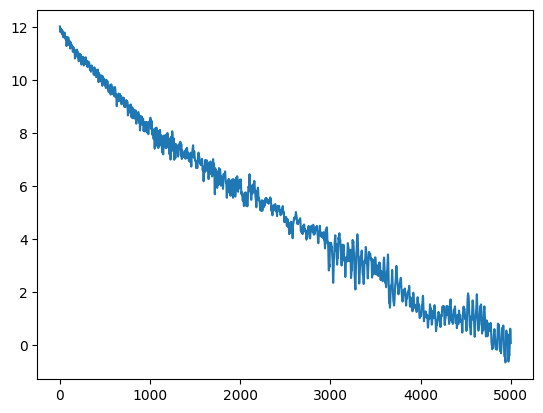

In [193]:
plt.plot(data3)

In [200]:
print('First_line_identifier::::should be kept here')
print('Sample : co6nm')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230817p4_Fe2O3VNA_n3dBmS21_sample_tilt30deg'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

numpts=5001
sfreq=1
efreq=20
freq_list=np.linspace(sfreq,efreq,numpts)
Hlist=np.linspace(20,10,41)
sweepcount=1

OnOff=1
dt=[]

try:
    setVNA_S21(**dict(starfreq=sfreq,stopfreq=efreq,pts=numpts,bw=1e3,power=-3))
    time.sleep(2)
    for i,hfield in enumerate(Hlist):   
        time1=time.time()
        change_curr_local(hfield)
        time.sleep(1)
        vnadata=getVNAdata_S21()
        time.sleep(1) 

        Ncol=1
        data_raw=np.zeros((Ncol,numpts))
        data_raw[0] = vnadata

        status=stopper('status.py')
        if status=='STOP':
            print('Measurement has been stopped')
            time.sleep(1)
            raise StopIteration

        data=np.array([data_raw[0]])

        if sweepcount==1:
            fp=open(fname+'.dat','a')
        else:
            pass
        np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
        fp.flush() # flush all buffer data to a file


        time2=time.time()
        TotN=len(Hlist)
        if sweepcount==TotN:
            fp.close()
        dt.append((time2-time1)/60)
        dtmean=np.mean(dt)
        tleft=dtmean*(TotN-sweepcount)
        print('Time left : %.4f minutes'%(tleft))
        print('Completed scan %d out of %d'%(sweepcount-1,TotN))
        sweepcount=sweepcount+1

except StopIteration:
    fp.close()
print('Total time elapsed %.3f mins'%((time2-time_start)/60))

First_line_identifier::::should be kept here
Sample : co6nm
start at : 2023.8.17,14:56
The following commands were written to file `temp.py`:
print('First_line_identifier::::should be kept here')
print('Sample : co6nm')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230817p4_Fe2O3VNA_n3dBmS21_sample_tilt30deg'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

numpts=5001
sfreq=1
efreq=20
freq_list=np.linspace(sfreq,efreq,numpts)
Hlist=np.linspace(20,10,41)
sweepcount=1

OnOff=1
dt=[]

try:
    setVNA_S21(**dict(starfreq=sfreq,stopfreq=efreq,pts=numpts,bw=1e3,power=-3))
    time.sleep(2)
    for i,hfield in enumerate(Hlist):   
        time1=time.time()
        change_curr_local(hfield)
        time.sleep(1)


C:\Users\KRISS_BLS\AppData\Local\Temp\ipykernel_1456\1757257548.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'history -n -f history.py')
C:\Users\KRISS_BLS\AppData\Local\Temp\ipykernel_1456\1757257548.py:13: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))


Time left : 6.6074 minutes
Completed scan 0 out of 41
Time left : 6.4416 minutes
Completed scan 1 out of 41
Time left : 6.2779 minutes
Completed scan 2 out of 41
Time left : 6.1125 minutes
Completed scan 3 out of 41
Time left : 5.9482 minutes
Completed scan 4 out of 41
Time left : 5.7837 minutes
Completed scan 5 out of 41
Time left : 5.6195 minutes
Completed scan 6 out of 41
Time left : 5.4529 minutes
Completed scan 7 out of 41
Time left : 5.2879 minutes
Completed scan 8 out of 41
Time left : 5.1225 minutes
Completed scan 9 out of 41
Time left : 4.9571 minutes
Completed scan 10 out of 41
Time left : 4.7915 minutes
Completed scan 11 out of 41
Time left : 4.6261 minutes
Completed scan 12 out of 41
Time left : 4.4600 minutes
Completed scan 13 out of 41
Time left : 4.2946 minutes
Completed scan 14 out of 41
Time left : 4.1293 minutes
Completed scan 15 out of 41
Time left : 3.9639 minutes
Completed scan 16 out of 41
Time left : 3.7987 minutes
Completed scan 17 out of 41
Time left : 3.6333 m

# End of line